# ML Практическая работа 5
## Мурадян Денис

### Gradient Boosting

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denismuradyan/cleaned-dataset-of-used-cars")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cleaned-dataset-of-used-cars


In [2]:
import pandas as pd

df = pd.read_csv(f"{path}/cleaned_data_used_cars.csv")
df.head()

,id,price,year,condition,cylinders,odometer,title_status,description,posting_date,fuel_electric,...,transmission_manual,transmission_other,drive_fwd,drive_rwd,state_freq,region_freq,type_freq,paint_color_freq,te_model_oof,te_manufacturer_oof
0,7316356412,15000,2013,3,6,128000.0,0.0,2013 F-150 XLT V6 4 Door. Good condition. Leve...,2021-05-03 19:02:03,False,...,False,False,False,True,0.012329,0.000328,0.105321,0.209170,20228.583361,20136.757536
1,7316343444,27990,2012,2,8,68696.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 18:41:25,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.209170,24936.745669,24228.390664
2,7316304717,34590,2016,2,6,29499.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 17:41:33,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.148408,25099.600519,19914.615212
3,7316285779,35000,2019,3,6,43000.0,0.0,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,2021-05-03 17:12:59,False,...,False,False,False,False,0.012329,0.000328,0.105321,0.095670,21119.239527,16356.129063
4,7316257769,29990,2016,2,6,17302.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 16:31:14,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.105005,22501.109375,20019.638000


In [3]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)

## Цели и задачи

**Цель работы.** Исследовать и сравнить несколько реализаций градиентного бустинга на задаче бинарной классификации стоимости авто и выбрать конфигурацию с наилучшим качеством и устойчивостью обучения.

**Задачи:**
- Построить модели на основе градиентного бустинга: классический GradientBoostingClassifier, а также реализации XGBoost, LightGBM и CatBoost.
- Выполнить подбор гиперпараметров (Optuna) для каждой модели.
- Оценить качество по метрикам: Accuracy, macro-F1, ROC-AUC, LogLoss.
- Построить кривые обучения целевой функции (logloss) по итерациям для train и valid.
- Сравнить результаты между моделями и зафиксировать выводы.

## Теоретическая справка

**Градиентный бустинг** 

Ансамблевый метод, в котором композиция слабых моделей строится пошагово: на каждом шаге новое базовое дерево аппроксимирует направление антиградиента функции потерь в пространстве моделей (forward stagewise). Пусть $F_{m-1}(x)$ - текущая композиция, тогда добавляется $h_m(x)$ с весом $\eta$:
$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x).
$$
Для бинарной классификации обычно оптимизируют логарифмическую потерю:
$$
\text{LogLoss} = -\frac{1}{N}\sum_{i=1}^{N}\Big[y_i\log p_i + (1-y_i)\log(1-p_i)\Big],\quad p_i=\sigma(F(x_i)),
$$
где $\sigma(\cdot)$ - сигмоида. На каждом шаге строится дерево по псевдо-остаткам (отрицательным градиентам), что позволяет последовательно уменьшать ошибку.

**Классический GradientBoostingClassifier**

Использует деревья решений как базовые модели и пошагово минимизирует дифференцируемую функцию потерь. Важные элементы - малый шаг обучения $\eta$ (shrinkage) и число итераций $M$ (число деревьев). Усложнение дерева (глубина, число листьев) контролирует способность улавливать нелинейности. Стохастический вариант (subsample < 1) добавляет случайность и часто улучшает обобщающую способность. Кривые обучения по итерациям можно получить с помощью последовательных предсказаний ансамбля на каждом $m=1,\dots,M$.

**XGBoost**

Улучшает классический подход за счёт аппроксимации целевой функции вторым порядком и явной регуляризации структуры дерева. Оптимизируется функционал
$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^N\Big[g_i f_t(x_i) + \tfrac{1}{2}h_i f_t^2(x_i)\Big] + \Omega(f_t),\quad
\Omega(f)=\gamma T+\tfrac{\lambda}{2}\sum_{j=1}^{T}w_j^2,
$$
где $g_i$ и $h_i$ - градиенты и гессианы по предсказаниям, $T$ - число листьев, $w_j$ - вес листа. Оптимальный вес листа:
$$
w_j = -\frac{\sum_{i\in I_j} g_i}{\sum_{i\in I_j} h_i + \lambda},
$$
а прирост от сплита (gain) вычисляется как
$$
\text{Gain}=\frac{1}{2}\left(\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{G^2}{H+\lambda}\right)-\gamma,
$$
что даёт критерий для жадного построения дерева. Поддерживаются подвыборки по объектам/признакам, пропуски, ранняя остановка и широкий набор регуляризаторов.

**LightGBM** 

Реализует гистограммную оптимизацию признаков и рост деревьев по листьям (leaf-wise), что ускоряет обучение и часто повышает качество. Признаки бинируются в гистограммы, что ускоряет поиск сплитов и снижает использование памяти. Leaf-wise стратегия может давать более глубокие ветви в "информативных" частях пространства, поэтому обычно контролируется параметрами вроде `num_leaves`, `min_child_samples` и ограничением глубины. Дополнительно используются идеи GOSS и EFB для ускорения на больших данных. Есть встроенная валидация и ранняя остановка.

**CatBoost** 

Строит симметричные (oblivious) деревья - одна и та же последовательность сплитов применяется ко всем путям, что упрощает регуляризацию и ускоряет предсказание. Ключевая идея - ordered boosting: специальные порядки и схемы счёта статистик уменьшают смещение и утечку таргета. Хотя в исходной постановке CatBoost силён на категориальных признаках, на полностью числовых данных он тоже показывает конкурентоспособные результаты благодаря устойчивому процессу обучения, встроенным регуляризациям и дефолтным настройкам. В качестве функции потерь для бинарной классификации используется логлосс, есть ранняя остановка и логирование кривых ошибок.

**Кривые обучения и критерии сравнения** 

Для анализа динамики по итерациям строятся кривые logloss для обучающей и валидационной выборок. Для моделей, поддерживающих валидационные логи (XGBoost/LightGBM/CatBoost), кривые берутся из истории обучения; для классического бустинга - через последовательные предсказания ансамбля. Для итогового сравнения используются метрики Accuracy, macro-F1, ROC-AUC и LogLoss на отложенном тесте.


## Подготовка данных

Повторим ключевые шаги подготовки.

1) Удаление служебных признаков: id, description, posting_date.  
2) Булевы индикаторы (fuel_*, transmission_*, drive_*) -> int (0/1).  
3) Удаление пропусков по title_status.  
4) Целевой признак: target = (price > median(price)), затем price удалить.  
5) Признаки: берём все оставшиеся числовые столбцы, кроме target.  
6) Разбиение: train/valid/test = 70/15/15, stratify=target, random_state=42.

In [4]:
from sklearn.model_selection import train_test_split

# убрать служебные
drop_cols = [c for c in ['id', 'description', 'posting_date'] if c in df.columns]
df = df.drop(columns=drop_cols)

# bool -> int
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

# пропуски
if 'title_status' in df.columns:
    df = df.dropna(subset=['title_status'])

# целевой и удаление price
median_price = df['price'].median()
df['target'] = (df['price'] > median_price).astype(int)
if 'price' in df.columns:
    df = df.drop(columns=['price'])

# признаки = все оставшиеся числовые колонки, кроме target
TARGET = 'target'
feature_cols = [c for c in df.columns if c != TARGET]
X_full = df[feature_cols].select_dtypes(include=[np.number]).copy()
y_full = df[TARGET].copy()

# если остались NaN в признаках - удалим такие строки
mask_nan = X_full.isna().any(axis=1)
n_drop = int(mask_nan.sum())
if n_drop > 0:
    idx = X_full.index[mask_nan]
    df = df.drop(index=idx).reset_index(drop=True)
    X_full = df[[c for c in df.columns if c != TARGET]].select_dtypes(include=[np.number]).copy()
    y_full = df[TARGET].copy()

print("Features used:", X_full.shape[1])

# сплиты 70/15/15
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X_full, y_full, test_size=0.15, stratify=y_full, random_state=42
)
valid_size = 0.15 / 0.85
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=valid_size, stratify=y_train_valid, random_state=42
)

print("\nShapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_valid:", X_valid.shape, "y_valid:", y_valid.shape)
print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

print("\nClass balance (train/valid/test):")
for name, yy in [("train", y_train), ("valid", y_valid), ("test", y_test)]:
    vc = yy.value_counts(normalize=True).sort_index()
    print(f"{name}: class0={vc.get(0,0):.3f}, class1={vc.get(1,0):.3f}")

print("The number of omissions in each feature:")
print(df.isna().sum())

Features used: 19

Shapes:
  X_train: (121496, 19) y_train: (121496,)
  X_valid: (26035, 19) y_valid: (26035,)
  X_test : (26035, 19) y_test : (26035,)

Class balance (train/valid/test):
train: class0=0.501, class1=0.499
valid: class0=0.501, class1=0.499
test: class0=0.501, class1=0.499
The number of omissions in each feature:
year                   0
condition              0
cylinders              0
odometer               0
title_status           0
fuel_electric          0
fuel_gas               0
fuel_hybrid            0
fuel_other             0
transmission_manual    0
transmission_other     0
drive_fwd              0
drive_rwd              0
state_freq             0
region_freq            0
type_freq              0
paint_color_freq       0
te_model_oof           0
te_manufacturer_oof    0
target                 0
dtype: int64


### Базовые функции для экспериментов

Опишем вычисление метрик, обёртку для оценки модели и функцию для отрисовки кривых logloss по итерациям.

In [5]:
from typing import Dict, List, Tuple

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_proba) -> Dict[str, float]:
    """
    Возвращает словарь метрик:
    - accuracy (по argmax с порогом 0.5)
    - macro_f1
    - roc_auc
    - logloss
    """
    y_proba = np.asarray(y_proba).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "logloss": log_loss(y_true, np.c_[1 - y_proba, y_proba]),
    }

def plot_learning_curve(train_loss: List[float], valid_loss: List[float], title: str):
    plt.figure(figsize=(7, 4.5))
    plt.plot(train_loss, label="train logloss")
    plt.plot(valid_loss, label="valid logloss")
    plt.xlabel("Iteration")
    plt.ylabel("LogLoss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# таблица всех результатов
results = []
def add_result(model_name: str, split: str, metrics: Dict[str, float], note: str = ""):
    row = {"model": model_name, "split": split, **metrics}
    if note:
        row["note"] = note
    results.append(row)

def results_df() -> pd.DataFrame:
    cols = ["model", "split", "accuracy", "macro_f1", "roc_auc", "logloss", "note"]
    return pd.DataFrame(results)[cols].sort_values(["model", "split"]).reset_index(drop=True)


## GradientBoostingClassifier

Подберём гиперпараметры классического градиентного бустинга с помощью Optuna. Оптимизируем macro-F1 на валидации.

Диапазоны:
- n_estimators: 250..600
- learning_rate: 0.03..0.12 (log)
- max_depth: 3..5
- min_samples_leaf: 5..20
- min_samples_split: 8..30
- subsample: 0.65..0.95
- max_features: {None, "sqrt"}
> Используем TPE-сэмплер и MedianPruner, чтобы отбрасывать неудачные траектории. После подбора строим кривые logloss (train vs valid) и оцениваем качество на test. Затем обучим базовую модель без Optuna для сравнения.

После подбора покажем кривые logloss по итерациям (train vs valid) для лучшей конфигурации и обучим лучшую модель на train+valid и оценим на test

In [6]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.ensemble import GradientBoostingClassifier

def objective_skgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 250, 600),
        "learning_rate": trial.suggest_float("learning_rate", 3e-2, 1.2e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 8, 30),
        "subsample": trial.suggest_float("subsample", 0.65, 0.95),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt"]),
        "random_state": 42,
    }
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    proba_valid = model.predict_proba(X_valid)[:, 1]
    return compute_metrics(y_valid, proba_valid)["macro_f1"]

study_skgb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0),
)
study_skgb.optimize(objective_skgb, n_trials=12, show_progress_bar=True)

best_skgb_params = study_skgb.best_params
best_skgb_params["random_state"] = 42
print("Best params (SklearnGB):", best_skgb_params)

[I 2025-11-02 13:57:31,571] A new study created in memory with name: no-name-b5853ddd-16ca-48a6-9846-1018965ff825


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-11-02 13:57:59,467] Trial 0 finished with value: 0.935508474388852 and parameters: {'n_estimators': 381, 'learning_rate': 0.11207488496994687, 'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 11, 'subsample': 0.6967983561008608, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.935508474388852.
[I 2025-11-02 13:58:23,408] Trial 1 finished with value: 0.9269436052551985 and parameters: {'n_estimators': 460, 'learning_rate': 0.08006144509284034, 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 27, 'subsample': 0.7137017332034828, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.935508474388852.
[I 2025-11-02 13:58:45,357] Trial 2 finished with value: 0.9277121261257644 and parameters: {'n_estimators': 356, 'learning_rate': 0.062094925075927974, 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 22, 'subsample': 0.6918481581956125, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.935508474388852.
[I 2025-11-02 13:59:42,251] Trial 3

In [7]:
print("Number of finished trials:", len(study_skgb.trials))
print("Best trial:")
trial = study_skgb.best_trial

print("  Value (macro-F1):", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Number of finished trials: 12
Best trial:
  Value (macro-F1): 0.9375450366261009
  Params:
n_estimators: 272
learning_rate: 0.11179111120063062
max_depth: 5
min_samples_leaf: 17
min_samples_split: 15
subsample: 0.6793016342019151
max_features: None


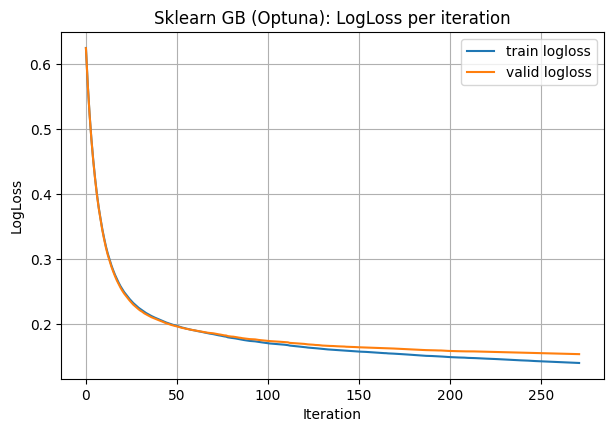

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,SklearnGB,test,0.936777,0.936777,0.984951,0.158588,optuna


In [8]:
# финальная модель с optuna
best_skgb = GradientBoostingClassifier(**best_skgb_params)
best_skgb.fit(X_train, y_train)

# кривые logloss (train vs valid)
train_losses, valid_losses = [], []
for p_tr, p_va in zip(
    best_skgb.staged_predict_proba(X_train),
    best_skgb.staged_predict_proba(X_valid)
):
    train_losses.append(log_loss(y_train, p_tr))
    valid_losses.append(log_loss(y_valid, p_va))

plot_learning_curve(train_losses, valid_losses, title="Sklearn GB (Optuna): LogLoss per iteration")

proba_test = best_skgb.predict_proba(X_test)[:, 1]
m_test = compute_metrics(y_test, proba_test)
add_result("SklearnGB", "test", m_test, note="optuna")

results_df().query("model == 'SklearnGB'")

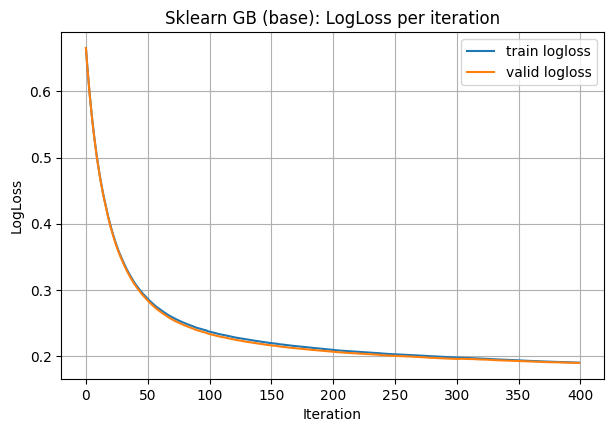

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,SklearnGB,test,0.936777,0.936777,0.984951,0.158588,optuna
1,SklearnGB,test,0.919224,0.919224,0.977388,0.195756,base


In [9]:
# базовая модель без Optuna
gb_base = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gb_base.fit(X_train, y_train)

eval_train = [log_loss(y_train, p) for p in gb_base.staged_predict_proba(X_train)]
eval_valid = [log_loss(y_valid, p) for p in gb_base.staged_predict_proba(X_valid)]
plot_learning_curve(eval_train, eval_valid, title="Sklearn GB (base): LogLoss per iteration")

proba_test_base = gb_base.predict_proba(X_test)[:, 1]
m_test_base = compute_metrics(y_test, proba_test_base)
add_result("SklearnGB", "test", m_test_base, note="base")

results_df().query("model == 'SklearnGB'")

### GradientBoostingClassifier - вывод

**Сравнение конфигураций (test):**
- Optuna: accuracy/macro-F1 = **0.9368**, ROC-AUC = **0.9850**, logloss = **0.1586**.  
- Base:   accuracy/macro-F1 = **0.9192**, ROC-AUC = **0.9774**, logloss = **0.1958**.

**Подобранные параметры:**  
`n_estimators=272`, `learning_rate≈0.112`, `max_depth=5`, `min_samples_leaf=17`, `min_samples_split=15`, `subsample≈0.679`, `max_features=None`, `random_state=42`.

**Кривые logloss:**  
- У Optuna-конфигурации валид. logloss монотонно убывает и финально ниже, чем у базовой; разрыв train/valid небольшой и стабильный - явных признаков переобучения нет.  
- У базовой модели снижение более медленное, финальное значение logloss выше.

**Интерпретация для задачи:**  
На табличных числовых признаках градиентный бустинг по деревьям даёт высокое качество для бинарной классификации стоимости авто. Оптимизация гиперпараметров заметно улучшила результат: выбран "умеренно быстрый" режим обучения (больше `learning_rate`, меньше `n_estimators`) при средней глубине дерева (`max_depth=5`) и стохастическом бустинге (`subsample≈0.68`), что обеспечило лучшее обобщение на тесте по всем метрикам.

## XGBoost

Подберем гиперпараметры XGBoost с помощью Optuna. Оптимизируем macro-F1 на валидации.

Диапазоны:
- n_estimators: 300..800
- learning_rate: 0.01..0.10 (log)
- max_depth: 4..7
- min_child_weight: 1..6
- subsample: 0.65..0.95
- colsample_bytree: 0.65..0.95
- reg_alpha: 0.0..3.0
- reg_lambda: 0.5..6.0
> Используем tree_method="hist" и early_stopping_rounds

После подбора построим кривые logloss по итерациям (train vs valid) и оценим качество на test.

In [10]:
from xgboost import XGBClassifier

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1.0e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.65, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.65, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 6.0),
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist",
    }
    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=30
    )
    proba_valid = model.predict_proba(X_valid)[:, 1]
    return compute_metrics(y_valid, proba_valid)["macro_f1"]

study_xgb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0),
)
study_xgb.optimize(objective_xgb, n_trials=16, show_progress_bar=True)

best_xgb_params = study_xgb.best_params
best_xgb_params.update({
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist",
})
print("Best params (XGBoost):", best_xgb_params)

[I 2025-11-02 14:09:35,852] A new study created in memory with name: no-name-1617c0b2-085f-4efd-8739-a9d326d07da0


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:09:43,217] Trial 0 finished with value: 0.9423456159503854 and parameters: {'n_estimators': 487, 'learning_rate': 0.08927180304353628, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.696805592132731, 'colsample_bytree': 0.6967983561008608, 'reg_alpha': 0.17425083650459838, 'reg_lambda': 5.263968801762143}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:09:50,677] Trial 1 finished with value: 0.930477461368458 and parameters: {'n_estimators': 601, 'learning_rate': 0.051059032093947576, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8997327922401265, 'colsample_bytree': 0.7137017332034828, 'reg_alpha': 0.5454749016213019, 'reg_lambda': 1.508724804193886}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:09:56,783] Trial 2 finished with value: 0.9302467751609688 and parameters: {'n_estimators': 452, 'learning_rate': 0.03347776308515933, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8335558684167138, 'colsample_bytree': 0.6918481581956125, 'reg_alpha': 0.8764339456056545, 'reg_lambda': 2.514990138115304}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:03,849] Trial 3 finished with value: 0.9316297686385941 and parameters: {'n_estimators': 528, 'learning_rate': 0.06097839109531514, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8277243706586127, 'colsample_bytree': 0.6639351238159993, 'reg_alpha': 1.822634555704315, 'reg_lambda': 1.4378826802801035}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:09,279] Trial 4 finished with value: 0.9415770026859799 and parameters: {'n_estimators': 332, 'learning_rate': 0.08889667907018929, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7413841307520113, 'colsample_bytree': 0.6793016342019151, 'reg_alpha': 2.052699079536471, 'reg_lambda': 2.920838715567807}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:13,971] Trial 5 finished with value: 0.9231021166992519 and parameters: {'n_estimators': 361, 'learning_rate': 0.03127353036780371, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7276339944800051, 'colsample_bytree': 0.8487566853061945, 'reg_alpha': 0.9351332282682329, 'reg_lambda': 3.3603741164779595}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:23,117] Trial 6 finished with value: 0.9336257498891265 and parameters: {'n_estimators': 573, 'learning_rate': 0.015305744365500184, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9318496824692567, 'colsample_bytree': 0.9184482051282946, 'reg_alpha': 1.7936999364332555, 'reg_lambda': 5.570308292627143}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:27,768] Trial 7 finished with value: 0.9134209256781749 and parameters: {'n_estimators': 344, 'learning_rate': 0.015703008378806716, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7666031869068446, 'colsample_bytree': 0.7314047095321687, 'reg_alpha': 2.486212527455788, 'reg_lambda': 2.462143296814741}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:33,411] Trial 8 finished with value: 0.9254839319799792 and parameters: {'n_estimators': 440, 'learning_rate': 0.03488960745139221, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6723651931039313, 'colsample_bytree': 0.9460660809801551, 'reg_alpha': 2.3167343078899725, 'reg_lambda': 1.5929362484379483}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:37,758] Trial 9 finished with value: 0.9362000442753551 and parameters: {'n_estimators': 302, 'learning_rate': 0.06538248584518043, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8813811040057837, 'colsample_bytree': 0.6722133955202271, 'reg_alpha': 1.0753971856328177, 'reg_lambda': 1.1372798273882134}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:48,719] Trial 10 finished with value: 0.9299384098004975 and parameters: {'n_estimators': 748, 'learning_rate': 0.010139048090380883, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6546103211984313, 'colsample_bytree': 0.781424278238549, 'reg_alpha': 0.04543271130827062, 'reg_lambda': 5.8687694492189735}. Best is trial 0 with value: 0.9423456159503854.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:10:59,745] Trial 11 finished with value: 0.9468785085897862 and parameters: {'n_estimators': 692, 'learning_rate': 0.0990364022837311, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7200341430619077, 'colsample_bytree': 0.7685202661129732, 'reg_alpha': 2.8468209753308873, 'reg_lambda': 4.473361386389962}. Best is trial 11 with value: 0.9468785085897862.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:11:09,463] Trial 12 finished with value: 0.9443815870440406 and parameters: {'n_estimators': 718, 'learning_rate': 0.09977171260113837, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7019007388862893, 'colsample_bytree': 0.7593326909715369, 'reg_alpha': 2.984165808081222, 'reg_lambda': 4.522118842691338}. Best is trial 11 with value: 0.9468785085897862.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:11:20,690] Trial 13 finished with value: 0.9479153536130656 and parameters: {'n_estimators': 736, 'learning_rate': 0.09884711108216601, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7730161991843357, 'colsample_bytree': 0.7869630069952889, 'reg_alpha': 2.9980873159246535, 'reg_lambda': 4.397215537630274}. Best is trial 13 with value: 0.9479153536130656.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:11:31,253] Trial 14 finished with value: 0.9431526252941997 and parameters: {'n_estimators': 666, 'learning_rate': 0.047644623751423754, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7892118719697466, 'colsample_bytree': 0.834166839849019, 'reg_alpha': 2.9855607921715586, 'reg_lambda': 4.088622817975395}. Best is trial 13 with value: 0.9479153536130656.


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[I 2025-11-02 14:11:44,137] Trial 15 finished with value: 0.9467630384275139 and parameters: {'n_estimators': 800, 'learning_rate': 0.07328816633915546, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7730648179208867, 'colsample_bytree': 0.8188687183755502, 'reg_alpha': 2.6165390651232734, 'reg_lambda': 4.525735356973985}. Best is trial 13 with value: 0.9479153536130656.
Best params (XGBoost): {'n_estimators': 736, 'learning_rate': 0.09884711108216601, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7730161991843357, 'colsample_bytree': 0.7869630069952889, 'reg_alpha': 2.9980873159246535, 'reg_lambda': 4.397215537630274, 'eval_metric': 'logloss', 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist'}


In [11]:
print("Number of finished trials:", len(study_xgb.trials))
print("Best trial:")
trial = study_xgb.best_trial

print("  Value (macro-F1):", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Number of finished trials: 16
Best trial:
  Value (macro-F1): 0.9479153536130656
  Params:
n_estimators: 736
learning_rate: 0.09884711108216601
max_depth: 7
min_child_weight: 3
subsample: 0.7730161991843357
colsample_bytree: 0.7869630069952889
reg_alpha: 2.9980873159246535
reg_lambda: 4.397215537630274


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


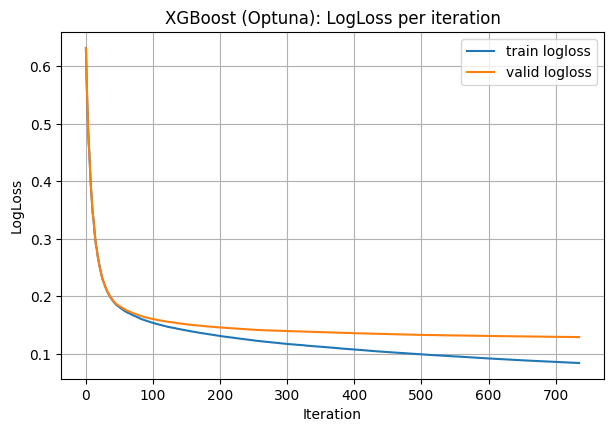

,model,split,accuracy,macro_f1,roc_auc,logloss,note
2,XGBoost,test,0.946534,0.946534,0.988778,0.135254,optuna


In [12]:
# финальная модель с optuna
from xgboost import XGBClassifier

best_xgb = XGBClassifier(**best_xgb_params)
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False,
    early_stopping_rounds=100
)

evals = best_xgb.evals_result()
train_losses = evals["validation_0"]["logloss"]
valid_losses = evals["validation_1"]["logloss"]

plot_learning_curve(train_losses, valid_losses, title="XGBoost (Optuna): LogLoss per iteration")

proba_test = best_xgb.predict_proba(X_test)[:, 1]
m_test = compute_metrics(y_test, proba_test)
add_result("XGBoost", "test", m_test, note="optuna")

results_df().query("model == 'XGBoost'")

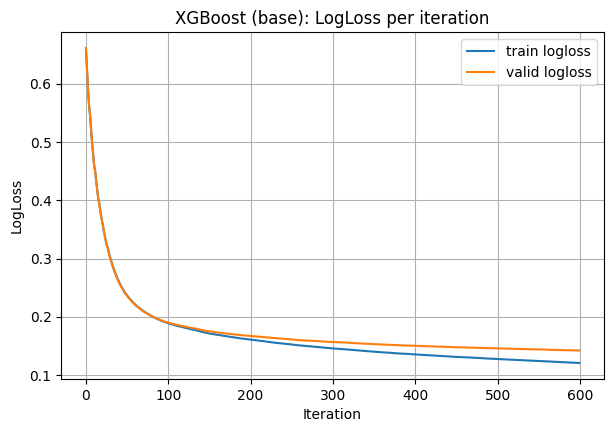

,model,split,accuracy,macro_f1,roc_auc,logloss,note
2,XGBoost,test,0.946534,0.946534,0.988778,0.135254,optuna
3,XGBoost,test,0.940426,0.940426,0.987036,0.147343,base


In [13]:
# базовая модель без Optuna
xgb_base = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
)
xgb_base.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)
evals_base = xgb_base.evals_result()
plot_learning_curve(evals_base["validation_0"]["logloss"], evals_base["validation_1"]["logloss"],
                    title="XGBoost (base): LogLoss per iteration")

proba_test_base = xgb_base.predict_proba(X_test)[:, 1]
m_test_base = compute_metrics(y_test, proba_test_base)
add_result("XGBoost", "test", m_test_base, note="base")

results_df().query("model == 'XGBoost'")

### XGBoost - вывод

**Сравнение конфигураций (test):**
- Optuna: accuracy/macro-F1 = **0.9465**, ROC-AUC = **0.9888**, logloss = **0.1353**.  
- Base:   accuracy/macro-F1 = **0.9404**, ROC-AUC = **0.9870**, logloss = **0.1473**.

**Лучшие параметры:**  
`n_estimators=736`, `learning_rate≈0.099`, `max_depth=7`, `min_child_weight=3`,  
`subsample≈0.77`, `colsample_bytree≈0.79`, `reg_alpha≈3.0`, `reg_lambda≈4.4`.

**Наблюдения по обучению:**  
На графике видно, что при подборе параметров ошибка на валидации убывает быстрее и достигает меньших значений.  
Разница между train и valid остаётся небольшой - модель не переобучается.  
У базовой версии кривая logloss снижается медленнее, что согласуется с чуть худшими метриками.

**Итог:**  
После подбора параметров XGBoost дал немного более точные предсказания и чуть лучше обобщает данные.  
В сравнении с классическим бустингом из sklearn он ведёт себя стабильнее и быстрее сходится при тех же объёмах данных.

## LightGBM

Подберем гиперпараметры LightGBM с помощью Optuna. Оптимизируем macro-F1 на валидации.

Диапазоны:
- n_estimators: 300..900
- learning_rate: 0.01..0.10 (log)
- num_leaves: 31..95
- max_depth: -1..10
- min_child_samples: 10..60
- subsample: 0.65..0.95
- colsample_bytree: 0.65..0.95
- reg_alpha: 0.0..3.0
- reg_lambda: 0.5..6.0
> Используем early_stopping 

После подбора построим кривые logloss по итерациям (train vs valid) и оценим качество на test.

In [14]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 3e-2, 1.0e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 63, 127),
        "max_depth": trial.suggest_int("max_depth", -1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 40),
        "subsample": trial.suggest_float("subsample", 0.80, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.80, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 6.0),
        "objective": "binary",
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1,
    }
    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=["binary_logloss", "auc"],
        callbacks=[early_stopping(stopping_rounds=30), log_evaluation(0)],
    )
    proba_valid = model.predict_proba(X_valid)[:, 1]
    return compute_metrics(y_valid, proba_valid)["macro_f1"]

study_lgbm = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0),
)
study_lgbm.optimize(objective_lgbm, n_trials=16, show_progress_bar=True)

best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({
    "objective": "binary",
    "random_state": 42,
    "n_jobs": -1,
})
print("Best params (LightGBM):", best_lgbm_params)

[I 2025-11-02 14:12:05,793] A new study created in memory with name: no-name-9f2c1e44-0af4-4fc6-b3d7-68b7974a80f5


  0%|          | 0/16 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[525]	valid_0's binary_logloss: 0.138173	valid_0's auc: 0.98855
[I 2025-11-02 14:12:10,530] Trial 0 finished with value: 0.9433826833408275 and parameters: {'n_estimators': 525, 'learning_rate': 0.09423875899553878, 'num_leaves': 110, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8233991780504304, 'colsample_bytree': 0.80871254182523, 'reg_alpha': 2.5985284373248057, 'reg_lambda': 3.8061325645876485}. Best is trial 0 with value: 0.9433826833408275.
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[725]	valid_0's binary_logloss: 0.135567	valid_0's auc: 0.9891
[I 2025-11-02 14:12:19,389] Trial 1 finished with value: 0.9443043321734936 and parameters: {'n_estimators': 725, 'learning_rate': 0.030752784807119137, 'num_leaves': 126, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8272737450810651, 'colsample

In [15]:
print("Number of finished trials:", len(study_lgbm.trials))
print("Best trial:")
trial = study_lgbm.best_trial

print("  Value (macro-F1):", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Number of finished trials: 16
Best trial:
  Value (macro-F1): 0.9517565801774102
  Params:
n_estimators: 898
learning_rate: 0.06569367854347771
num_leaves: 83
max_depth: 10
min_child_samples: 25
subsample: 0.9050272455282987
colsample_bytree: 0.9060120915247949
reg_alpha: 1.6019249630144001
reg_lambda: 0.6006061852316069


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[897]	training's binary_logloss: 0.0635707	training's auc: 0.998769	valid_1's binary_logloss: 0.122403	valid_1's auc: 0.990776


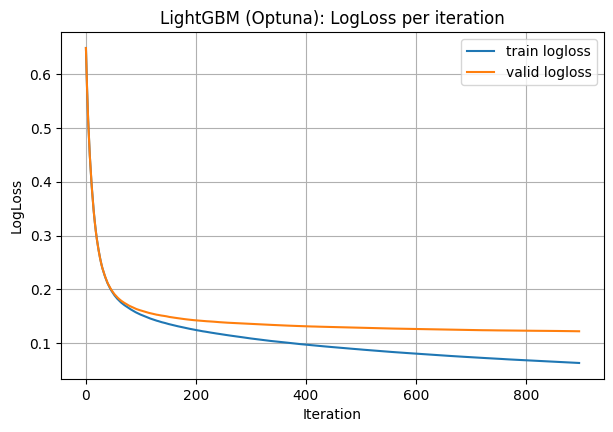

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,LightGBM,test,0.949184,0.949184,0.989801,0.128543,optuna


In [16]:
# финальная модель с optuna
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, record_evaluation
evals_result = {}

best_lgbm = LGBMClassifier(**best_lgbm_params)
best_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric=["binary_logloss", "auc"],
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(0),
        record_evaluation(evals_result),
    ],
)

train_losses = evals_result["training"]["binary_logloss"]
valid_losses = evals_result["valid_1"]["binary_logloss"]

plot_learning_curve(train_losses, valid_losses, title="LightGBM (Optuna): LogLoss per iteration")

proba_test = best_lgbm.predict_proba(X_test)[:, 1]
m_test = compute_metrics(y_test, proba_test)
add_result("LightGBM", "test", m_test, note="optuna")

results_df().query("model == 'LightGBM'")

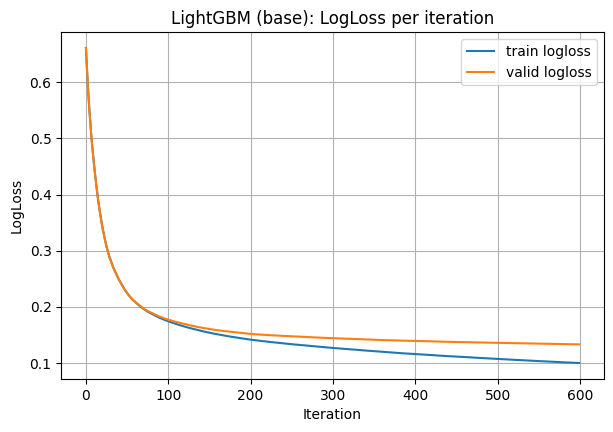

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,LightGBM,test,0.949184,0.949184,0.989801,0.128543,optuna
1,LightGBM,test,0.944344,0.944344,0.988547,0.138325,base


In [17]:
# базовая модель без Optuna
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, record_evaluation
evals_result_base = {}

lgbm_base = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary",
    random_state=42,
    n_jobs=-1,
)

lgbm_base.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric=["binary_logloss", "auc"],
    callbacks=[log_evaluation(0), record_evaluation(evals_result_base)],
)

train_losses_base = evals_result_base["training"]["binary_logloss"]
valid_losses_base = evals_result_base["valid_1"]["binary_logloss"]

plot_learning_curve(
    train_losses_base,
    valid_losses_base,
    title="LightGBM (base): LogLoss per iteration"
)

proba_test_base = lgbm_base.predict_proba(X_test)[:, 1]
m_test_base = compute_metrics(y_test, proba_test_base)
add_result("LightGBM", "test", m_test_base, note="base")

results_df().query("model == 'LightGBM'")

### LightGBM - вывод

**Сравнение конфигураций (test):**
- Optuna: accuracy/macro-F1 = **0.9492**, ROC-AUC = **0.9898**, logloss = **0.1285**.  
- Base:   accuracy/macro-F1 = **0.9443**, ROC-AUC = **0.9885**, logloss = **0.1383**.

**Лучшие параметры:**  
`n_estimators=898`, `learning_rate≈0.066`, `num_leaves=83`, `max_depth=10`,  
`min_child_samples=25`, `subsample≈0.91`, `colsample_bytree≈0.91`,  
`reg_alpha≈1.6`, `reg_lambda≈0.6`.

**Наблюдения по обучению:**  
Обе модели сходятся устойчиво: logloss быстро снижается в начале и стабилизируется после ~200 итераций.  
У оптимизированной версии кривая валидации проходит ниже и достигает меньшего значения ошибки,  
при этом разрыв между train и valid умеренный - переобучения нет.  
У базовой модели валидационная ошибка снижается медленнее, что соответствует немного худшим метрикам.

**Итог:**  
Подбор гиперпараметров позволил немного улучшить качество LightGBM:  
точность и F1 выросли примерно на 0.5 %, logloss снизился, а модель стала чуть стабильнее на валидации.  
По форме кривых видно, что обучение идёт плавно и без резких скачков - бустинг хорошо подстроился под данные.

## CatBoost

Подберем гиперпараметры CatBoost с помощью Optuna. Оптимизируем macro-F1 на валидации.

Диапазоны:
- iterations: 400..1100  
- learning_rate: 0.015..0.12 (log)  
- depth: 4..9  
- l2_leaf_reg: 0.5..8.0  
- subsample: 0.6..1.0  
- border_count: 64..256  

> Используем GPU и `bootstrap_type="Poisson"`, при котором объекты для отдельных деревьев выбираются стохастически, что уменьшает корреляцию между деревьями и ускоряет обучение.  
Доп, включаем `early_stopping_rounds`

In [18]:
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 400, 1100),
        "learning_rate": trial.suggest_float("learning_rate", 1.5e-2, 1.2e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 8.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "border_count": trial.suggest_int("border_count", 64, 256),
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "random_seed": 42,
        "logging_level": "Silent",
        "allow_writing_files": False,
        "bootstrap_type": "Poisson",
        "task_type": "GPU",
    }
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        use_best_model=True,
        early_stopping_rounds=30,
        verbose=False
    )
    proba_valid = model.predict_proba(X_valid)[:, 1]
    return compute_metrics(y_valid, proba_valid)["macro_f1"]

study_cat = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0),
)
study_cat.optimize(objective_cat, n_trials=30, show_progress_bar=True)

best_cat_params = study_cat.best_params
best_cat_params.update({
    "loss_function": "Logloss",
    "eval_metric": "Logloss",
    "random_seed": 42,
    "logging_level": "Silent",
    "allow_writing_files": False,
    "bootstrap_type": "Poisson",
    "task_type": "GPU",
})
print("Best params (CatBoost):", best_cat_params)

[I 2025-11-02 14:14:15,917] A new study created in memory with name: no-name-2f42e1cd-2e7a-4629-aad0-ded407172247


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-02 14:14:27,794] Trial 0 finished with value: 0.9432675890395541 and parameters: {'iterations': 662, 'learning_rate': 0.10831081647339098, 'depth': 8, 'l2_leaf_reg': 4.9899386314777745, 'subsample': 0.6624074561769746, 'border_count': 94}. Best is trial 0 with value: 0.9432675890395541.
[I 2025-11-02 14:14:31,540] Trial 1 finished with value: 0.9362387177698073 and parameters: {'iterations': 440, 'learning_rate': 0.09085027856438452, 'depth': 7, 'l2_leaf_reg': 5.810544333470341, 'subsample': 0.608233797718321, 'border_count': 251}. Best is trial 0 with value: 0.9432675890395541.
[I 2025-11-02 14:14:36,791] Trial 2 finished with value: 0.927481349485707 and parameters: {'iterations': 983, 'learning_rate': 0.023326661313163164, 'depth': 5, 'l2_leaf_reg': 1.8755338239007537, 'subsample': 0.7216968971838151, 'border_count': 165}. Best is trial 0 with value: 0.9432675890395541.
[I 2025-11-02 14:14:42,342] Trial 3 finished with value: 0.9318216952247672 and parameters: {'iteration

In [19]:
print("Number of finished trials:", len(study_cat.trials))
print("Best trial:")
trial = study_cat.best_trial

print("  Value (macro-F1):", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Number of finished trials: 30
Best trial:
  Value (macro-F1): 0.9521793505181675
  Params:
iterations: 948
learning_rate: 0.11493917712652706
depth: 9
l2_leaf_reg: 1.5516283798840849
subsample: 0.8172516615493127
border_count: 138


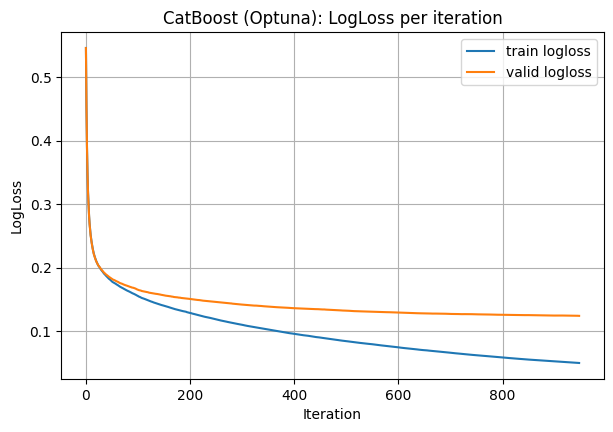

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,CatBoost,test,0.950451,0.950451,0.989392,0.130638,optuna


In [20]:
# обучение финальной модели с Optuna
from catboost import CatBoostClassifier

best_cat = CatBoostClassifier(**best_cat_params)
best_cat.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    use_best_model=True,
    early_stopping_rounds=50,
    verbose=False
)

evals = best_cat.get_evals_result()
plot_learning_curve(
    evals["learn"]["Logloss"],
    evals["validation"]["Logloss"],
    title="CatBoost (Optuna): LogLoss per iteration"
)

proba_test = best_cat.predict_proba(X_test)[:, 1]
m_test = compute_metrics(y_test, proba_test)
add_result("CatBoost", "test", m_test, note="optuna")

results_df().query("model == 'CatBoost'")

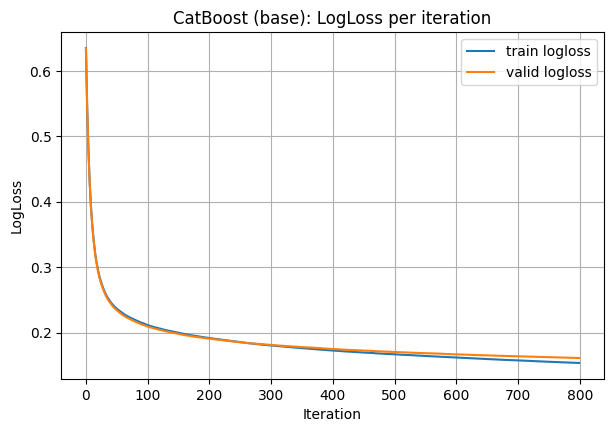

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,CatBoost,test,0.950451,0.950451,0.989392,0.130638,optuna
1,CatBoost,test,0.930478,0.930478,0.983501,0.166776,base


In [21]:
# базовая модель без Optuna
cat_base = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    subsample=0.8,
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    logging_level="Silent",
    allow_writing_files=False,
    bootstrap_type="Poisson",
    task_type="GPU",
)

cat_base.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    use_best_model=True,
    early_stopping_rounds=50,
    verbose=False
)

evals_base = cat_base.get_evals_result()
plot_learning_curve(
    evals_base["learn"]["Logloss"],
    evals_base["validation"]["Logloss"],
    title="CatBoost (base): LogLoss per iteration"
)

proba_test_base = cat_base.predict_proba(X_test)[:, 1]
m_test_base = compute_metrics(y_test, proba_test_base)
add_result("CatBoost", "test", m_test_base, note="base")

results_df().query("model == 'CatBoost'")

### CatBoost - вывод

**Сравнение конфигураций (test):**  
- Optuna: accuracy/macro-F1 = **0.9505**, ROC-AUC = **0.9894**, logloss = **0.1306**.  
- Base:   accuracy/macro-F1 = **0.9305**, ROC-AUC = **0.9835**, logloss = **0.1668**.  

**Лучшие параметры:**  
`iterations=948`, `learning_rate≈0.115`, `depth=9`, `l2_leaf_reg≈1.55`,  
`subsample≈0.82`, `border_count=138`, `bootstrap_type="Poisson"`.  

**Наблюдения по обучению:**  
Обе версии сходятся уверенно: logloss на валидации быстро падает в начале и постепенно выходит на плато.  
У модели с Optuna кривая валидации идёт заметно ниже, что подтверждает более точное приближение без переобучения.  
Базовая версия обучается плавно, но остаётся на более высоком уровне ошибок.  

**Итог:**  
После подбора параметров, метрики выросли по всем показателям, особенно по F1 и logloss, а процесс обучения стал более стабильным. Модель с оптимизацией быстрее достигает хорошего качества и держит его без признаков деградации на валидации.

## Итоговые результаты:

In [22]:
df_all = results_df().sort_values(by="macro_f1", ascending=False).reset_index(drop=True)
display(df_all)

,model,split,accuracy,macro_f1,roc_auc,logloss,note
0,CatBoost,test,0.950451,0.950451,0.989392,0.130638,optuna
1,LightGBM,test,0.949184,0.949184,0.989801,0.128543,optuna
2,XGBoost,test,0.946534,0.946534,0.988778,0.135254,optuna
3,LightGBM,test,0.944344,0.944344,0.988547,0.138325,base
4,XGBoost,test,0.940426,0.940426,0.987036,0.147343,base
5,SklearnGB,test,0.936777,0.936777,0.984951,0.158588,optuna
6,CatBoost,test,0.930478,0.930478,0.983501,0.166776,base
7,SklearnGB,test,0.919224,0.919224,0.977388,0.195756,base


### Итоговый вывод

**Что сделали:** Использовали четыре реализации бустинга: классический `GradientBoostingClassifier` (sklearn) и три вариации - XGBoost, LightGBM, CatBoost. Данные подготовлены так же, как в предыдущих дз: бинарный таргет `(price > median)`. Для каждой модели есть две конфигурации: базовая и с подбором гиперпараметров через Optuna. Для всех построены кривые logloss (train vs valid).

**Сводка по качеству на тесте:**  
По F1 и logloss впереди связка **CatBoost/LightGBM** с Optuna; по ROC-AUC первое место у **LightGBM (Optuna)**. Разрыв между топ-2 и XGBoost небольшой, но стабильный. Классический sklearn-GB уступает всем трем реализациям, что ожидаемо: у него меньше "рычагов" по регуляризации и выбору сплиттера, а также нет гистограммного обучения.

**Влияние Optuna:**  
- CatBoost: F1 +2.0 %, logloss -0.036  
- LightGBM: F1 +0.5 %, logloss -0.010  
- XGBoost: F1 +0.6 %, logloss -0.012  
- Sklearn GB: F1 +1.8 %, logloss -0.037

На кривых видно более низкую валидную ошибку и ровную динамику у оптимизированных конфигураций.

**Почему бустинг здесь работает:**  
Задача - бинарная классификация цены относительно медианы; признаки числовые и разной природы (год, пробег, кодировки категорий). Деревья ловят нелинейности и взаимодействия без ручного фичеринга, а бустинг накапливает много слабых правил в точную композицию.

**Наблюдения по кривым обучения:**  
У всех реализаций быстрый спад logloss в начале и дальнейшее сглаживание. У лучших моделей (CatBoost/LightGBM с Optuna) train ниже valid, но не критично - так как разница в сотых, а валидационная кривая стабилизируется около ~0.12-0.13 без провалов.

**Итоговая расстановка:**  
Для практического использования в текущей постановке уместны **LightGBM (Optuna)** или **CatBoost (Optuna)**:  
- LightGBM дает лучший ROC-AUC и минимальный logloss,  
- CatBoost немного выше по F1/accuracy.  

Разница минимальна, поэтому выбор можно делать по нефункциональным критериям: время обучения, наличие GPU, удобство дальнейшего анализа и тд